#Imports

In [86]:
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from numpy import sort
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Load Data

In [87]:
LOANS_TRAIN = pd.read_csv('https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/LOANS_TRAIN.csv')
LOANS_TEST = pd.read_csv('https://raw.githubusercontent.com/charlesincharge/Caltech-CS155-2022/main/miniprojects/LOANS_TEST.csv')

#Data Wrangling

In [4]:
train_data = pd.DataFrame()
#Keep loan amount the same
train_data['loan_amnt'] = LOANS_TRAIN['loan_amnt']
#Keep loan term the same, only has 36 or 60 so could do 0/1: [0 if x == 36 else 1 for x in LOANS_TRAIN['term_(months)']]
train_data['term'] = LOANS_TRAIN['term_(months)']
#Convert interest rate to a float
train_data['int_rate'] = [float(x.strip(" ").strip("%")) for x in LOANS_TRAIN['int_rate']]
#Keep installment the same
train_data['installment'] = LOANS_TRAIN['installment']
#Change grade from A-G to 0-6
train_data['grade'] = [ord(x)-65 for x in LOANS_TRAIN['grade']]
#Change subgrade from A1-G5 to 0-4,10-14,..,60-64
train_data['sub_grade'] = [10*(ord(x[0])-65)+int(x[1])-1 for x in LOANS_TRAIN['sub_grade']]
#Dropping emp_title column because 119834 unique out of 197249 total
#Convert emp length from <1, 1, ..., 9, 10+ to 0-10, nan value coded as -1 should decide what to do with nan
train_data['emp_length'] = [-1 if pd.isna(x) else 0 if '<' in x else int(x.strip(" years").strip("+")) for x in LOANS_TRAIN['emp_length']]
#Home ownership has rent, own, mortgage, other, none, so making a column for each of these
#better than a single column with these coded as numbers??
train_data['ownership_rent'] = [1 if x == 'RENT' else 0 for x in LOANS_TRAIN['home_ownership']]
train_data['ownership_own'] = [1 if x == 'OWN' else 0 for x in LOANS_TRAIN['home_ownership']]
train_data['ownership_mortgage'] = [1 if x == 'MORTGAGE' else 0 for x in LOANS_TRAIN['home_ownership']]
train_data['ownership_other'] = [1 if x == 'OTHER' else 0 for x in LOANS_TRAIN['home_ownership']]
train_data['ownership_none'] = [1 if x == 'NONE' else 0 for x in LOANS_TRAIN['home_ownership']]
#Keep annual income the same
train_data['annual_inc'] = LOANS_TRAIN['annual_inc']
#Verification status has verified, source verified, not verified, so making a column for each of these
#better than a single column with these coded as numbers?? could also do single column 0 for not verified 1 for other two
train_data['status_verified'] = [1 if x == 'Verified' else 0 for x in LOANS_TRAIN['verification_status']]
train_data['status_source_verified'] = [1 if x == 'Source Verified' else 0 for x in LOANS_TRAIN['verification_status']]
train_data['status_not_verified'] = [1 if x == 'Not Verified' else 0 for x in LOANS_TRAIN['verification_status']]
#Not sure what to do with issue date so split into issue year and issue month
#Issue year changed from 2007-2013 to 0-6
train_data['issue_year'] = [int(x[-4:])-2007 for x in LOANS_TRAIN['issue_d']]
#Issue month changed from jan-dec to 0-11
train_data['issue_month'] = [datetime.datetime.strptime(x[:3], "%b").month-1 for x in LOANS_TRAIN['issue_d']]
#Purpose has multiple options so making a column for each of these
train_data['purpose_credit_card'] = [1 if x == 'credit_card' else 0 for x in LOANS_TRAIN['purpose']]
train_data['purpose_car'] = [1 if x == 'car' else 0 for x in LOANS_TRAIN['purpose']]
train_data['purpose_small_business'] = [1 if x == 'small_business' else 0 for x in LOANS_TRAIN['purpose']]
train_data['purpose_other'] = [1 if x == 'other' else 0 for x in LOANS_TRAIN['purpose']]
train_data['purpose_wedding'] = [1 if x == 'wedding' else 0 for x in LOANS_TRAIN['purpose']]
train_data['purpose_debt_consolidation'] = [1 if x == 'debt_consolidation' else 0 for x in LOANS_TRAIN['purpose']]
train_data['purpose_home_improvement'] = [1 if x == 'home_improvement' else 0 for x in LOANS_TRAIN['purpose']]
train_data['purpose_major_purchase'] = [1 if x == 'major_purchase' else 0 for x in LOANS_TRAIN['purpose']]
train_data['purpose_medical'] = [1 if x == 'medical' else 0 for x in LOANS_TRAIN['purpose']]
train_data['purpose_moving'] = [1 if x == 'moving' else 0 for x in LOANS_TRAIN['purpose']]
train_data['purpose_vacation'] = [1 if x == 'vacation' else 0 for x in LOANS_TRAIN['purpose']]
train_data['purpose_house'] = [1 if x == 'house' else 0 for x in LOANS_TRAIN['purpose']]
train_data['purpose_renewable_energy'] = [1 if x == 'renewable_energy' else 0 for x in LOANS_TRAIN['purpose']]
train_data['purpose_educational'] = [1 if x == 'educational' else 0 for x in LOANS_TRAIN['purpose']]
#Dropping title column because 53461 unique out of 197249 total
#Dropping zip_code column because 855 unique out of 197249 total, could also do numerical as below
# train_data['zip_code'] = [int(x[:3]) for x in LOANS_TRAIN['zip_code']]
#Dropping state column because idk what to do for this
#Keep dti the same
train_data['dti'] = LOANS_TRAIN['dti']
#Not sure what to do with issue date so split into issue year and issue month
#Issue year changed from 1946-2010 to 0-64
train_data['cr_line_year'] = [int(x[-4:])-1946 for x in LOANS_TRAIN['earliest_cr_line']]
#Issue month changed from jan-dec to 0-11
train_data['cr_line_month'] = [datetime.datetime.strptime(x[:3], "%b").month-1 for x in LOANS_TRAIN['earliest_cr_line']]
#Keep open_acc the same
train_data['open_acc'] = LOANS_TRAIN['open_acc']
#Keep pub_rec the same
train_data['pub_rec'] = LOANS_TRAIN['pub_rec']
#Keep revol_bal the same
train_data['revol_bal'] = LOANS_TRAIN['revol_bal']
#Convert revol_util to a float
train_data['revol_util'] = [-1 if pd.isna(x) else float(x.strip("%")) for x in LOANS_TRAIN['revol_util']]
#Keep total_acc the same
train_data['total_acc'] = LOANS_TRAIN['total_acc']
#Convert initial_list_status from f/w to 0/1
train_data['initial_list_status'] = [0 if x == 'f' else 1 for x in LOANS_TRAIN['initial_list_status']]
#Convert nan values to -1 for pub_rec_bankruptcies
train_data['pub_bankruptcies'] = [-1 if pd.isna(x) else x for x in LOANS_TRAIN['pub_rec_bankruptcies']]
#Dropping application type because all of them are individual
#Convert nan values to -1 for mort_acc
train_data['mort_acc'] = [-1 if pd.isna(x) else x for x in LOANS_TRAIN['mort_acc']]

train_data['loan_status'] = [1 if x == 'Charged Off' else 0 for x in LOANS_TRAIN['loan_status']]
#Setting intermediate states as the original states
train_data['addr_state'] = LOANS_TRAIN['addr_state']
#Setting each state value to be equal to the average of all thats states loan status (0/1)
state_means = {}
for x in train_data['addr_state'].unique():
    state_means[x] = train_data[train_data['addr_state']==x]['loan_status'].mean()
train_data['addr_state'] = [state_means[x] for x in train_data['addr_state']]
train_data.drop('loan_status', inplace=True, axis=1)

train_labels = pd.DataFrame()
#For now making our loan_status with 0 as charged off and 1 as fully paid
train_labels['loan_status'] = [1 if x == 'Charged Off' else 0 for x in LOANS_TRAIN['loan_status']]

In [5]:
test_data = pd.DataFrame()
#Keep loan amount the same
test_data['loan_amnt'] = LOANS_TEST['loan_amnt']
#Keep loan term the same, only has 36 or 60 so could do 0/1: [0 if x == 36 else 1 for x in LOANS_TRAIN['term_(months)']]
test_data['term'] = LOANS_TEST['term_(months)']
#Convert interest rate to a float
test_data['int_rate'] = [float(x.strip(" ").strip("%")) for x in LOANS_TEST['int_rate']]
#Keep installment the same
test_data['installment'] = LOANS_TEST['installment']
#Change grade from A-G to 0-6
test_data['grade'] = [ord(x)-65 for x in LOANS_TEST['grade']]
#Change subgrade from A1-G5 to 0-4,10-14,..,60-64
test_data['sub_grade'] = [10*(ord(x[0])-65)+int(x[1])-1 for x in LOANS_TEST['sub_grade']]
#Dropping emp_title column because 119834 unique out of 197249 total
#Convert emp length from <1, 1, ..., 9, 10+ to 0-10, nan value coded as -1 should decide what to do with nan
test_data['emp_length'] = [-1 if pd.isna(x) else 0 if '<' in x else int(x.strip(" years").strip("+")) for x in LOANS_TEST['emp_length']]
#Home ownership has rent, own, mortgage, other, none, so making a column for each of these
#better than a single column with these coded as numbers??
test_data['ownership_rent'] = [1 if x == 'RENT' else 0 for x in LOANS_TEST['home_ownership']]
test_data['ownership_own'] = [1 if x == 'OWN' else 0 for x in LOANS_TEST['home_ownership']]
test_data['ownership_mortgage'] = [1 if x == 'MORTGAGE' else 0 for x in LOANS_TEST['home_ownership']]
test_data['ownership_other'] = [1 if x == 'OTHER' else 0 for x in LOANS_TEST['home_ownership']]
test_data['ownership_none'] = [1 if x == 'NONE' else 0 for x in LOANS_TEST['home_ownership']]
#Keep annual income the same
test_data['annual_inc'] = LOANS_TEST['annual_inc']
#Verification status has verified, source verified, not verified, so making a column for each of these
#better than a single column with these coded as numbers?? could also do single column 0 for not verified 1 for other two
test_data['status_verified'] = [1 if x == 'Verified' else 0 for x in LOANS_TEST['verification_status']]
test_data['status_source_verified'] = [1 if x == 'Source Verified' else 0 for x in LOANS_TEST['verification_status']]
test_data['status_not_verified'] = [1 if x == 'Not Verified' else 0 for x in LOANS_TEST['verification_status']]
#Not sure what to do with issue date so split into issue year and issue month
#Issue year changed from 2007-2013 to 0-6
test_data['issue_year'] = [int(x[-4:])-2007 for x in LOANS_TEST['issue_d']]
#Issue month changed from jan-dec to 0-11
test_data['issue_month'] = [datetime.datetime.strptime(x[:3], "%b").month-1 for x in LOANS_TEST['issue_d']]
#Purpose has multiple options so making a column for each of these
test_data['purpose_credit_card'] = [1 if x == 'credit_card' else 0 for x in LOANS_TEST['purpose']]
test_data['purpose_car'] = [1 if x == 'car' else 0 for x in LOANS_TEST['purpose']]
test_data['purpose_small_business'] = [1 if x == 'small_business' else 0 for x in LOANS_TEST['purpose']]
test_data['purpose_other'] = [1 if x == 'other' else 0 for x in LOANS_TEST['purpose']]
test_data['purpose_wedding'] = [1 if x == 'wedding' else 0 for x in LOANS_TEST['purpose']]
test_data['purpose_debt_consolidation'] = [1 if x == 'debt_consolidation' else 0 for x in LOANS_TEST['purpose']]
test_data['purpose_home_improvement'] = [1 if x == 'home_improvement' else 0 for x in LOANS_TEST['purpose']]
test_data['purpose_major_purchase'] = [1 if x == 'major_purchase' else 0 for x in LOANS_TEST['purpose']]
test_data['purpose_medical'] = [1 if x == 'medical' else 0 for x in LOANS_TEST['purpose']]
test_data['purpose_moving'] = [1 if x == 'moving' else 0 for x in LOANS_TEST['purpose']]
test_data['purpose_vacation'] = [1 if x == 'vacation' else 0 for x in LOANS_TEST['purpose']]
test_data['purpose_house'] = [1 if x == 'house' else 0 for x in LOANS_TEST['purpose']]
test_data['purpose_renewable_energy'] = [1 if x == 'renewable_energy' else 0 for x in LOANS_TEST['purpose']]
test_data['purpose_educational'] = [1 if x == 'educational' else 0 for x in LOANS_TEST['purpose']]
#Dropping title column because 53461 unique out of 197249 total
#Dropping zip_code column because 855 unique out of 197249 total, could also do numerical as below
# train_data['zip_code'] = [int(x[:3]) for x in LOANS_TRAIN['zip_code']]
#Dropping state column because idk what to do for this
#Keep dti the same
test_data['dti'] = LOANS_TEST['dti']
#Not sure what to do with issue date so split into issue year and issue month
#Issue year changed from 1946-2010 to 0-64
test_data['cr_line_year'] = [int(x[-4:])-1946 for x in LOANS_TEST['earliest_cr_line']]
#Issue month changed from jan-dec to 0-11
test_data['cr_line_month'] = [datetime.datetime.strptime(x[:3], "%b").month-1 for x in LOANS_TEST['earliest_cr_line']]
#Keep open_acc the same
test_data['open_acc'] = LOANS_TEST['open_acc']
#Keep pub_rec the same
test_data['pub_rec'] = LOANS_TEST['pub_rec']
#Keep revol_bal the same
test_data['revol_bal'] = LOANS_TEST['revol_bal']
#Convert revol_util to a float
test_data['revol_util'] = [-1 if pd.isna(x) else float(x.strip("%")) for x in LOANS_TEST['revol_util']]
#Keep total_acc the same
test_data['total_acc'] = LOANS_TEST['total_acc']
#Convert initial_list_status from f/w to 0/1
test_data['initial_list_status'] = [0 if x == 'f' else 1 for x in LOANS_TEST['initial_list_status']]
#Convert nan values to -1 for pub_rec_bankruptcies
test_data['pub_bankruptcies'] = [-1 if pd.isna(x) else x for x in LOANS_TEST['pub_rec_bankruptcies']]
#Dropping application type because all of them are individual
#Convert nan values to -1 for mort_acc
test_data['mort_acc'] = [-1 if pd.isna(x) else x for x in LOANS_TEST['mort_acc']]
#Setting intermediate states as the original states
test_data['addr_state'] = LOANS_TEST['addr_state']
#Setting each state value to be equal to the average of all thats states loan status (0/1)
test_data['addr_state'] = [state_means[x] if x in state_means else train_labels['loan_status'].mean() for x in test_data['addr_state']]

##XGBoost Models

In [42]:
dtrain = xgb.DMatrix(train_data, label=train_labels)
param = {'max_depth': 5, 'eta': .2, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
num_round = 100
bst = xgb.train(param, dtrain, num_round)
dtest = xgb.DMatrix(test_data)
ypred = bst.predict(dtest)
ypred
np.mean(ypred)
out = pd.DataFrame({'id':np.array([i for i in range(200000,200000+len(ypred))]),
       'loan_status': ypred})
out

In [40]:
out.to_csv("ben_xgb_testing_5.csv",index=False)

##Feature importance / selection

In [81]:
X_train, X_test, y_train, y_test = train_test_split(np.array(train_data), np.ravel(np.array(train_labels)), test_size = 0.3, random_state=8)
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(train_data.columns))
model = XGBClassifier(
    learning_rate = 0.07,
    max_depth = 3,
    n_estimators = 600,
    min_child_weight = 3,
    objective = 'binary:logistic',
    eval_metric = 'auc',
    nthread = 4,
    gamma = 7,
    colsample_bytree = 0.9
)
model.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.9, eval_metric='auc', gamma=6.5,
              learning_rate=0.07, min_child_weight=3, n_estimators=600,
              nthread=4)

In [85]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.80%


In [73]:
dtrain = xgb.DMatrix(train_data, label=train_labels, feature_names=list(train_data.columns))
param = {
    'max_depth': 3,
    'min_child_weight': 3,
    'gamma': 7,
    'subsample': 0.7,
    'colsample_bytree': 0.9,
    'n_estimators': 600, 
    'eta': 0.07, 
    'objective': 'binary:logistic',
    'nthread': 4,
    'eval_metric': 'auc'
    }
num_round = 100
bst = xgb.train(param, dtrain, num_round)

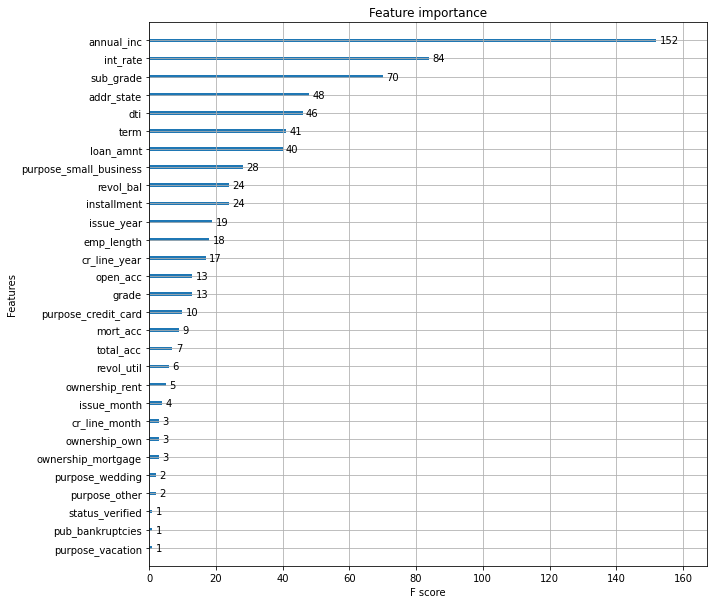

In [74]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_importance(bst, ax=ax, importance_type="weight")
plt.show()

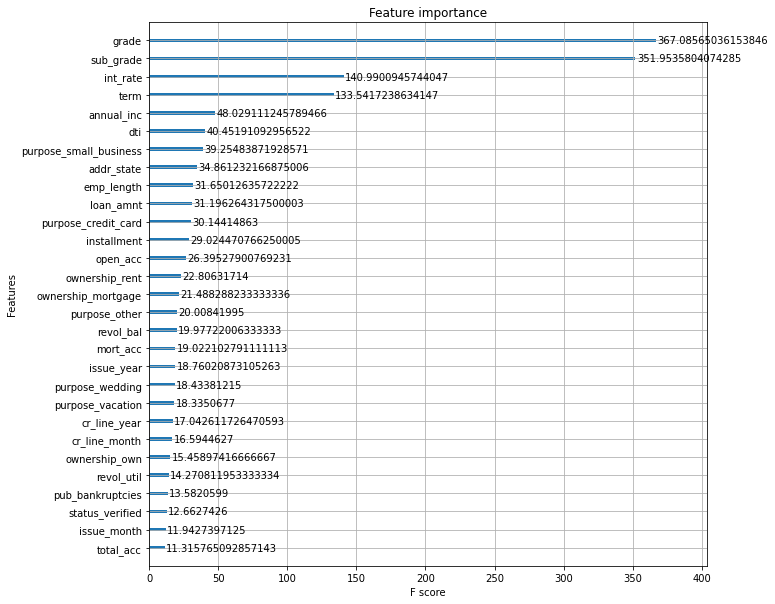

In [75]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_importance(bst, ax=ax, importance_type="gain")
plt.show()

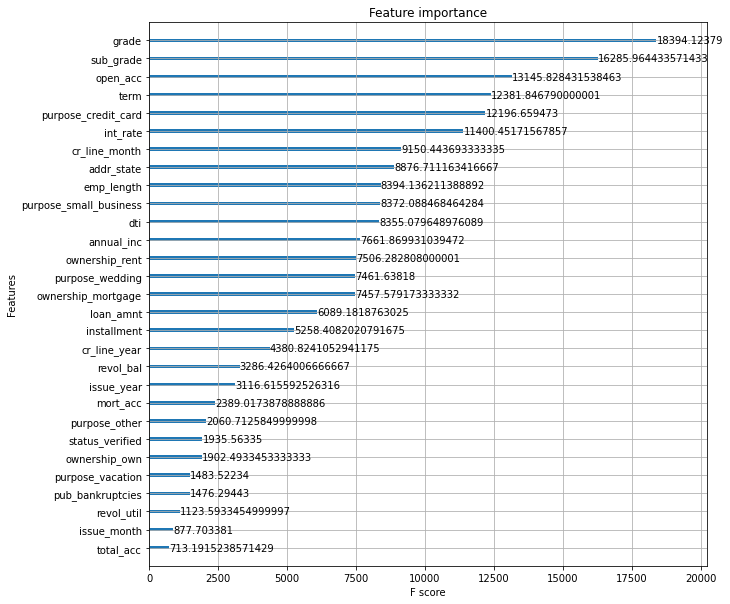

In [76]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_importance(bst, ax=ax, importance_type="cover")
plt.show()